In [38]:
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt

# function used to fit complexity curve
from scipy.optimize import curve_fit

### Methods

#### Algorithms

In [172]:
# global parameters

# algoritms 

# plots 

# approximation
lower_cut = 1 # starting point of aproximation 


In [ ]:
def gradient_descent(x0, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6):
    # local variables
    history = [x0]
    symbols = list(func_sp.free_symbols)
    x = np.array(x0)

    # calculating grad
    grad = [sp.diff(func_sp, var) for var in func_sp.free_symbols]
    # lambdify gradient 
    grad = sp.lambdify(func_sp.free_symbols, grad)

    # iterating 
    for _ in range(max_iter):
        next_x = x - learning_rate * np.array(grad(*x.tolist()))
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
    return np.array(history)

In [ ]:
def stochatic_gradient_descent(x0, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6):
    # local variables
    history = [x0]
    symbols = list(func_sp.free_symbols)
    x = np.array(x0)

    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]

    # iterating 
    for _ in range(max_iter):
        # chosing f_it
        f_it = np.random.choice(grad)
        f_it = sp.lambdify(symbols, f_it)
        # calculating next point
        next_x = x - learning_rate * np.array(f_it(*x.tolist()))
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
    return np.array(history)

In [ ]:
def momentum_gradient_descent(x0, beta, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6):
    # local variables
    history = [x0]
    symbols = list(func_sp.free_symbols) 
    x = np.array(x0)
    m = 0
    
    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]
    # lambdify gradient 
    grad = sp.lambdify(symbols, grad)
    
    # iterating  
    for _ in range(max_iter):
        # finding momentum
        next_m = beta * m + np.array(grad(*x.tolist()))
        # calculating new point
        next_x = x - learning_rate * next_m 
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
        m = next_m 
    return np.array(history)

In [165]:
def adam_gradient_descent(x0, func_sp, learning_rate=0.01, max_iter=100, tol=1e-6, b1=0.9, b2=0.999, epsilon = 1e-8):
    # local variables
    history = [x0]
    symbols = list(func_sp.free_symbols) 
    x = np.array(x0)
    m = 0
    v = 0
    
    # calculating grad
    grad = [sp.diff(func_sp, var) for var in symbols]
    # lambdify gradient 
    grad = sp.lambdify(symbols, grad)
    
    # iterating  
    for t in range(1, max_iter + 1): # we need to move index by one because we divide by zero
        # finding moments
        next_m = b1 * m + (1 - b1) * np.array(grad(*x.tolist()))
        next_m = next_m / (1 - b1**t)
        next_v = b2 * v + (1- b2) * np.array(grad(*x.tolist()))**2
        next_v = next_v / (1  -b2**t)
        # calculating new point 
        next_x = x - learning_rate * next_m / (np.sqrt(next_v) + epsilon)
        # checking condition
        if tol and np.linalg.norm(next_x - x) < tol:
            break
        # updating variables
        history.append(next_x)
        x = next_x
        m = next_m
        v = next_v
    return np.array(history)

#### Plots

In [5]:

def plot_3d(func: callable, func_g: list, interval: list, func_name: str):
    # local variables
    a, b = interval
    dens = int(np.ceil(b - a) * 10)
    # initiating 
    fig ,ax = plt.subplots(subplot_kw={'projection': '3d'})
    arg_range = np.linspace(a, b, dens)
    xx, yy = np.meshgrid(arg_range, arg_range)
    z = func(xx, yy)

    # plotting 
    ax.plot_surface(xx, yy, z, cmap='viridis', alpha=0.7)

    # gradient trajectory 
    ax.scatter(func_g[:, 0], func_g[:, 1], func(func_g[:, 0], func_g[:, 1]), color='red')

    # arrows indicating move 
    for i in range(len(func_g) - 1):
        # values 
        x, y, x_n, y_n = *func_g[i, :], *func_g[i + 1, :]
        ax.quiver(x, y, func(x, y),
                x_n - x, y_n - y, func(x_n, y_n) - func(x, y), 
                color='red', arrow_length_ratio=0.1, alpha=0.7)

    # description 
    ax.set_title(f"Gradient Descent on {func_name}")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x, y)')
    plt.show()

In [6]:
def plot_3d_on_2d(func: callable, func_g: list, interval: list, lvl: float, func_name: str):
    # creating local variables 
    a, b = interval
    dens = int(np.ceil(b-a) * 10)
    # initiating 
    arg_range = np.linspace(a, b, dens)
    xx, yy = np.meshgrid(arg_range, arg_range)
    z = func(xx, yy)

    # level set 
    z_max, z_min = z.max(), z.min()
    levels = int(np.ceil(z_max - z_min) * lvl)
    contour = plt.contour(xx, yy, z, levels=levels, cmap='viridis')
    plt.clabel(contour, inline=True, fontsize=8)

    # gradient trajectories 
    plt.scatter(func_g[:, 0], func_g[:, 1], color='red', label='Gradient Path')
    # gradient arrows 
    for i in range(len(func_g) - 1):
        x, y, x_n, y_n = *func_g[i, :], *func_g[i+1, :]
        plt.quiver(x, y, 
                x_n - x, y_n - y,
                angles='xy', scale_units='xy', scale=1.1, color='red', alpha=0.9)

    # display 
    # plt.colorbar(contour)
    plt.title(f"Gradient Descent on {func_name} (Contour Plot)")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.show()

In [173]:
def plot_complexity(dist: list, func_t: callable, func_t_param: list, complexity: str, m: str = 'png'):
    """
    Funkcja rysująca porównanie zbieżności metody gradientu z teoretyczną złożonością.

    Parametry:
    - dist (list): Lista odległości w każdej iteracji.
    - func_t (callable): Teoretyczna funkcja zbieżności.
    - func_t_param (list): Lista symboli funkcji (parametry).
    - complexity (str): Opis teoretycznej złożoności.
    - m (str): Format zapisu wykresu (np. 'png', 'jpg', 'svg').
    """
    # Local variables
    n = len(dist)
    x = sp.Symbol('x')

    # domains
    dom_dis = [i for i in range(n)]
    dom_con = np.linspace(1, n, (n-1) * 10)

    # lambify functnio
    func_t_lamb = sp.lambdify((x, *func_t_param), func_t)
    # fitting curve to plot
    popt, _ = curve_fit(func_t_lamb, dom_dis[lower_cut:], dist[lower_cut:])
    # creating str for theoritcal function
    func_t_names = {key: format(value, '.2g') 
                    for key, value in zip(func_t_param, popt)}
    func_t_name = sp.latex(func_t.subs(func_t_names))

    # plot
    plt.figure(figsize=(12, 8))
    # real data 
    plt.plot(dom_dis, dist, label='Rzeczywista odległość vs iteracja', 
             color='blue', marker='o', linestyle='-', linewidth=2)
    # fitted function 
    plt.plot(dom_con, func_t_lamb(dom_con, *popt), 
             label=f'${func_t_name}$\nTeoretyczna złożoność: {complexity}', 
             color='red', linestyle='--', linewidth=2)

    # plot setting 
    plt.title(f'Porównanie rzeczywistej zbieżności z teoretyczną złożonością\nZłożoność: {complexity}', fontsize=16)
    plt.xlabel('Iteracja', fontsize=14)
    plt.ylabel('Odległość', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=12)

    # plot save 
    # plt.savefig(f'plot_complexity.{m}', format=m, dpi=300)
    plt.show()


zaimplementowane w optimize 

### Tests

RSS (residual sum of squares) method 

In [123]:
# parameters

n = 10 # lenght of probe 
xi = sp.symbols(f'x0:{n}') # creating n variables 
yi = sp.symbols(f'y0:{n}') # 

# creating RRS function
RSS = sum((xi[i] - yi[i])**2 for i in range(n))
RRS_d = [sp.diff(RSS, xi[i]) for i in range(n)]

# z tego możemy wybierać sobie zmienne



<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:29: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_530709/2746858795.py:29: SyntaxWarning: invalid escape sequence '\m'
  plot_complexity(dist_gd, a/x + b, (a, b), 'complexity $\mathcal{O}(\\frac{1}{t})$')
/tmp/ipykernel_530709/2746858795.py:30: SyntaxWarning: invalid escape sequence '\m'
  plot_complexity(dist_sgd, a/x + b, (a, b), 'complexity $\mathcal{O}(\\frac{1}{t})$')
/tmp/ipykernel_530709/2746858795.py:31: SyntaxWarning: invalid escape sequence '\m'
  plot_complexity(dist_mgd,a/x + b, (a, b), 'Complexity $\mathcal{O}(\\frac{1}{t^2})$')
/tmp/ipykernel_530709/2746858795.py:32: SyntaxWarning: invalid escape sequence 

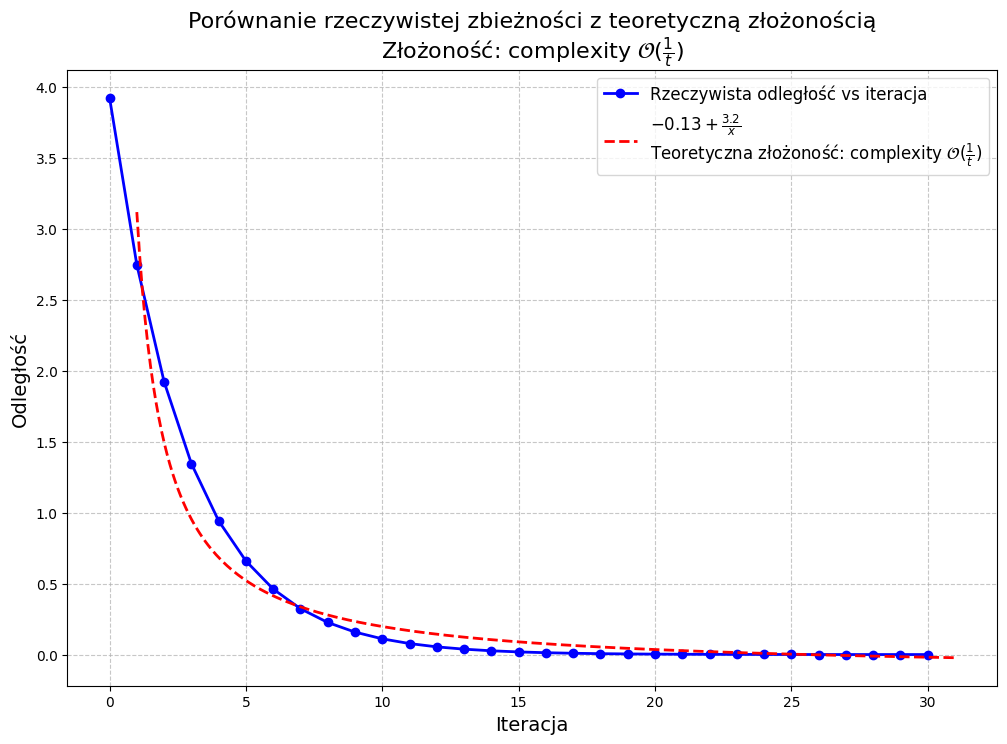

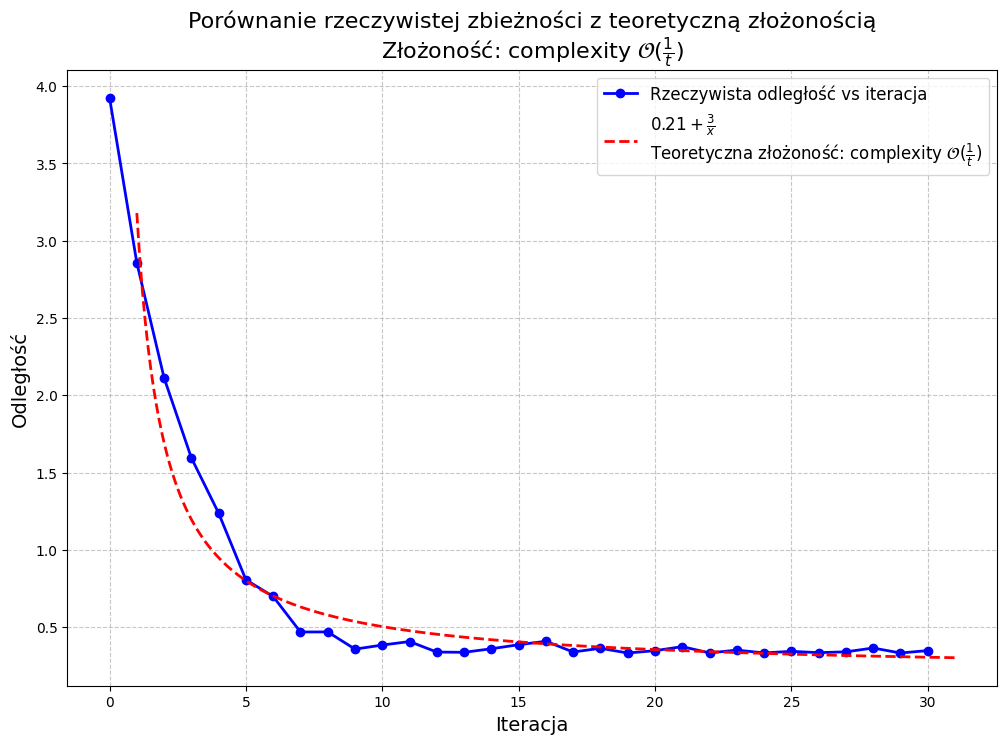

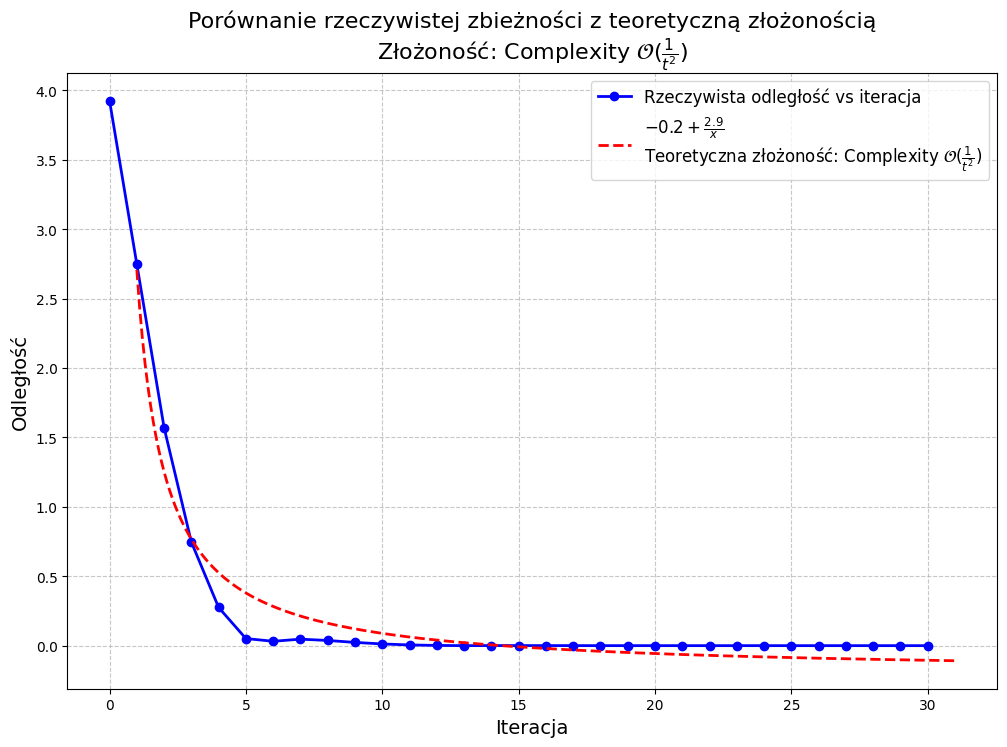

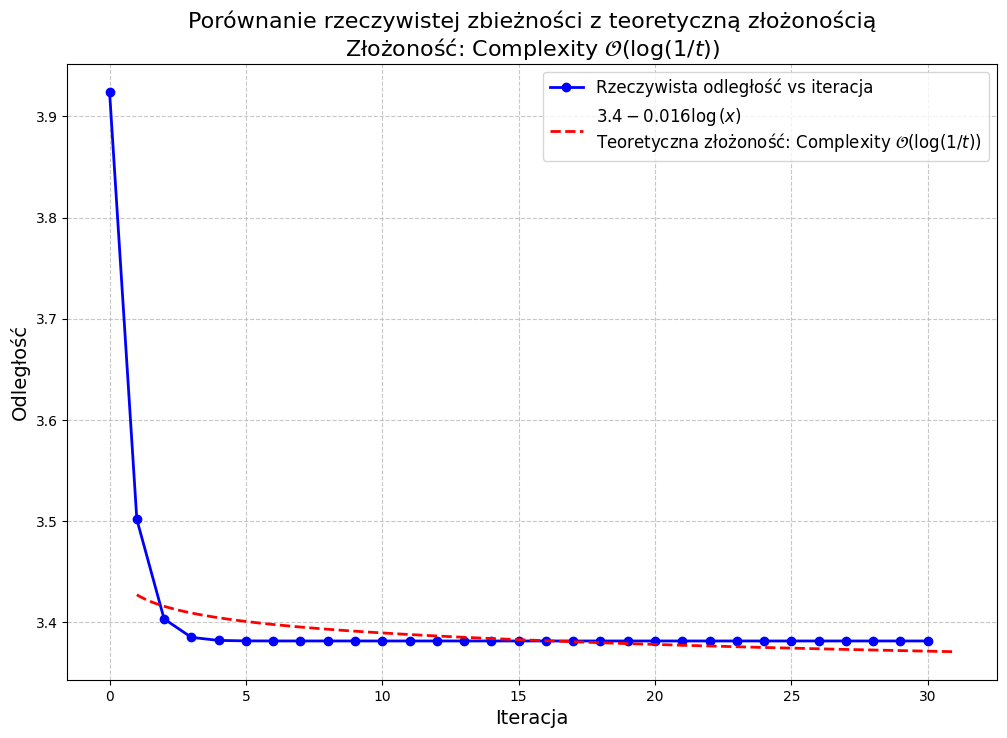

In [174]:
# parameters
lr = 0.3
n_iter = 30
x_init = (3, 3)
x_final = (0, 0.47)

# creating function
x, y = sp.symbols('x y')
tf = 5/10 * (x**2 + (y- 0.47)**2)   


# calculating aproximations 
tf_g_val_gd = gradient_descent(x_init, tf, lr, n_iter, None)
tf_g_val_sgd = stochatic_gradient_descent(x_init, tf, lr, n_iter, None)
tf_g_val_mgd = momentum_gradient_descent(x_init, 0.3, tf, lr, n_iter, None)
tf_g_val_adam = adam_gradient_descent(x_init, tf, lr, n_iter, None)

# compare them (distance) to known minimum (analitically)
dist_gd = abs(tf_g_val_gd - x_final)
dist_gd = np.sqrt(dist_gd[:, 0]**2 + dist_gd[:, 1]**2)
dist_sgd = abs(tf_g_val_sgd - x_final)
dist_sgd = np.sqrt(dist_sgd[:, 0]**2 + dist_sgd[:, 1]**2)
dist_mgd = abs(tf_g_val_mgd - x_final)
dist_mgd = np.sqrt(dist_mgd[:, 0]**2 + dist_mgd[:, 1]**2)
dist_adam = abs(tf_g_val_adam - x_final)
dist_adam = np.sqrt(dist_adam[:, 0]**2 + dist_adam[:, 1]**2)

a, b = sp.symbols('a, b')
plot_complexity(dist_gd, a/x + b, (a, b), 'complexity $\mathcal{O}(\\frac{1}{t})$')
plot_complexity(dist_sgd, a/x + b, (a, b), 'complexity $\mathcal{O}(\\frac{1}{t})$')
plot_complexity(dist_mgd,a/x + b, (a, b), 'Complexity $\mathcal{O}(\\frac{1}{t^2})$')
plot_complexity(dist_adam,a * sp.log(x) + b, (a, b), 'Complexity $\mathcal{O}(\log(1/t))$')